In [1]:
invisible(capture.output({
library(dplyr) # for functions
}))
profiles_dir <- "/home/ido/br_stat_profiler/qerr_profiles"
profile <- "All.GATKReport.mm_cntxt.4.profile.raw.csv"
file_path_4 <- file.path(profiles_dir, profile)
profile_4 <- read.csv(file_path_4, na.strings = "",, row.names = 1)

profile <- "All.GATKReport.mm_cntxt.6.profile.raw.csv"
file_path_6 <- file.path(profiles_dir, profile)
profile_6 <- read.csv(file_path_6, na.strings = "",, row.names = 1)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
invisible(capture.output({
    library(matrixStats)
}))
cutoff_complete_cases <- function(cutoff,profile_df) {
    profile_df[abs(profile_df) < cutoff] <- NA
    data.frame(profile_df[complete.cases(profile_df), ])
}

cutoff_scale_complete_cases <- function(cutoff, profile_df) {
    df <- data.frame()
    df <- cutoff_complete_cases(cutoff, profile_df) %>%
        scale() %>% as.data.frame() %>% mutate_all(~as.numeric(.))
    df
}

ALL_ROWS = -1
get_top_sds <- function(sds_count, df) {
    # print(sds_count)
    # print(nrow(df))
    sds <- rowSds(as.matrix(df), na.rm = TRUE)
    o <- order(sds, decreasing = TRUE)
    if (sds_count > nrow(df)) {
        return (NA)
    }
    if (sds_count == ALL_ROWS) {
        return(df[o,])
    }
    df[o[1:sds_count],]
}

cutoff_and_get_top_sds <- function(sds_count, cutoff, profile_df) {
    prf_cutoffed_df <- cutoff_scale_complete_cases(cutoff, profile_df)
    return (get_top_sds(sds_count, prf_cutoffed_df))
}


get_function_grid <- function(top_sds, cutoffs, df, my_func) {    
    result <- outer(top_sds, cutoffs, Vectorize(function(a, b) my_func(a, b, df)))
    result_df <- data.frame(result)
    top_sds[length(top_sds)] = "ALL_ROWS"
    rownames(result_df) <- top_sds
    colnames(result_df) <- cutoffs
    result_df
}


##################################################### PCI ######################################################

get_PCI <- function(profile_df) {
    cleaned_scaled_prf = data.frame()
    cleaned_scaled_prf <- profile_df
    
    d <- dist(t(cleaned_scaled_prf))  
    h_cl <- hclust(d)
    cluster_labels <- cutree(h_cl, k = 2)  # Assuming you want to separate into 2 clusters (tumor and normal)

    sample_names <- colnames(cleaned_scaled_prf)
    tumor_samples <- sample_names[grep("T\\.bam$",sample_names)]
    normal_samples <- sample_names[grep("N\\.bam$",sample_names)]
    # normal_indices <- grep("N\\.bam$", names(cluster_labels))
    # tumor_indices <- grep("T\\.bam$", names(cluster_labels))

    concordant_pairs <- sum(cluster_labels[tumor_samples]  == 2) + sum(cluster_labels[normal_samples]  == 1) 
    discordant_pairs <-  sum(cluster_labels[normal_samples]  == 2) + sum(cluster_labels[tumor_samples]  == 1) 
    total_pairs <- concordant_pairs + discordant_pairs
    PCI <- concordant_pairs / total_pairs
    round(PCI,2)
}

cutoff_and_get_PCI <- function(cutoff, profile_df) {
    cleaned_scaled_prf = data.frame()
    cleaned_scaled_prf <- cutoff_scale_complete_cases(cutoff, profile_df)
    get_PCI(cleaned_scaled_prf)
}


cutoff_and_top_sds_get_PCI <- function(sds_count, cutoff, profile_df) {
    cleaned_scaled_prf <- data.frame(cutoff_and_get_top_sds(sds_count, cutoff, profile_df))
    if (anyNA(cleaned_scaled_prf[1,1])) {
        return(NA)
    }
    get_PCI(cleaned_scaled_prf)
}



get_pci_grid <- function(top_sds, cutoffs, df) {   
        return(get_function_grid(top_sds, cutoffs, df, cutoff_and_top_sds_get_PCI))
}

####################################  Silhouette #################################
library(cluster)
get_silhouette_score <- function(df) {
    d <- dist(t(df))
    h_cl <- hclust(d)
    si <- silhouette(cutree(h_cl, k=2), d)
    round(summary(si)$avg.width,2)
}

cutoff_and_get_silhouette_score <- function(cutoff, profile_df){
    cleaned_scaled_prf <- data.frame()
    cleaned_scaled_prf <-  cutoff_scale_complete_cases(cutoff, profile_df)
    return(get_silhouette_score(cleaned_scaled_prf))
}

cutoff_and_top_sds_get_silhouette_score <- function(sds_count, cutoff, profile_df) {
    cleaned_scaled_prf <- data.frame(cutoff_and_get_top_sds(sds_count, cutoff, profile_df))
    if (anyNA(cleaned_scaled_prf[1,1])) {
        return(NA)
    }
    get_silhouette_score(cleaned_scaled_prf)
}


get_silhouette_grid <- function(top_sds, cutoffs, df) {   
        return(get_function_grid(top_sds, cutoffs, df, cutoff_and_top_sds_get_silhouette_score))
}

############################################ T-test ############################################################

add_t_test <- function(df){
    tumor_cols <- colnames(df)[grep("T\\.bam$", colnames(df))]
    normal_cols <- colnames(df)[grep("N\\.bam$", colnames(df))]

    p_values <- apply(df, 1, function(row) {
    ttest_result <- t.test(row[tumor_cols], row[normal_cols])
    ttest_result$p.value
    })
    t_test_df = data.frame(df)
    t_test_df["T-Test"] = p_values
    return(t_test_df)
} 


get_avg_ttest_profile <- function(cutoff, profile_df) {
    t_test_df <- data.frame()
    t_test_df <- add_t_test(cutoff_scale_complete_cases(cutoff, profile_df))
    round(mean(t_test_df[,"T-Test"]),2)
}



cutoff_and_top_sds_get_avg_ttest <- function(sds_count, cutoff, profile_df) {
    cleaned_scaled_prf <- data.frame(cutoff_and_get_top_sds(sds_count, cutoff, profile_df))
    if (anyNA(cleaned_scaled_prf[1,1])) {
        return(NA)
    }
    t_test_df <- data.frame()
    t_test_df <- add_t_test(cleaned_scaled_prf)
    round(mean(t_test_df[,"T-Test"]),2)
}

get_avg_ttest_grid <- function(top_sds, cutoffs, df) {   
        return(get_function_grid(top_sds, cutoffs, df, cutoff_and_top_sds_get_avg_ttest))
}



Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count




### Noise cleaning for increased sensitivity 
1) Extract high Qerrs by using **Symetrical Cutoff**
2) Using **top SDs**

Warning message in heatmap.2(as.matrix(cutoff_and_get_top_sds(TOP_SDS, 0, profile_6)), :
“Discrepancy: Rowv is FALSE, while dendrogram is `both'. Omitting row dendogram.”


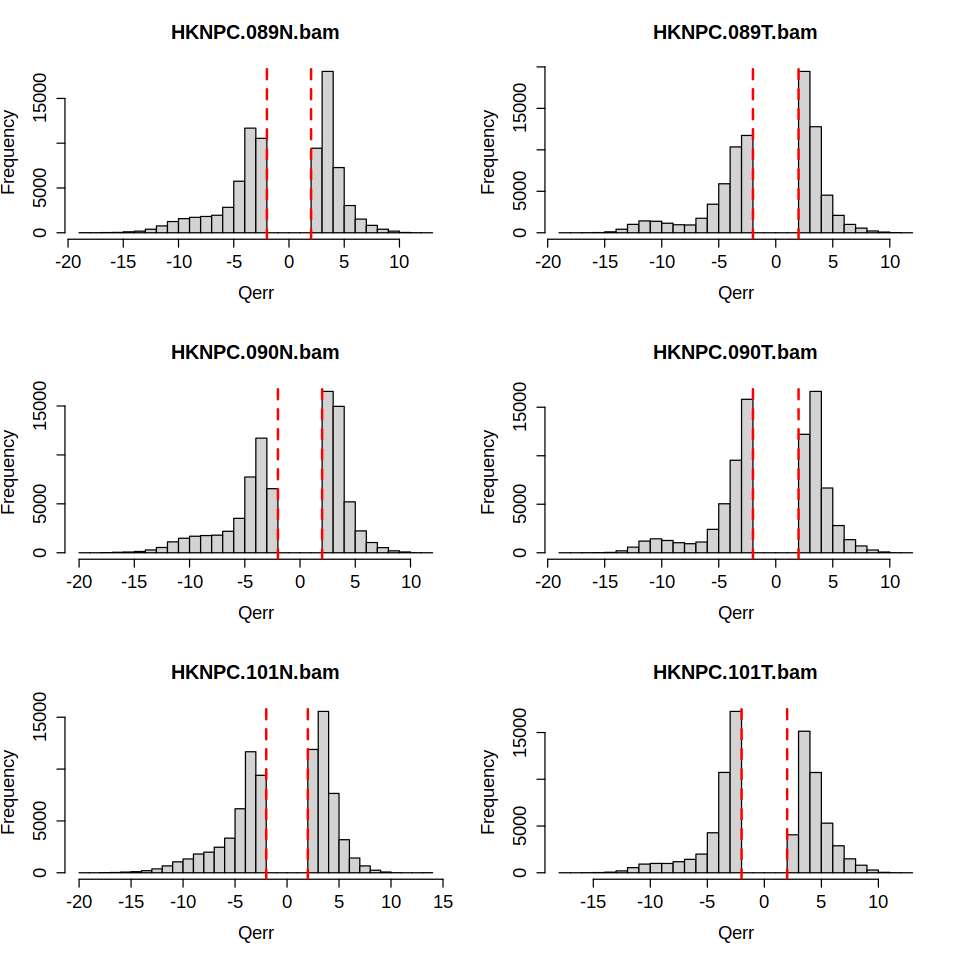

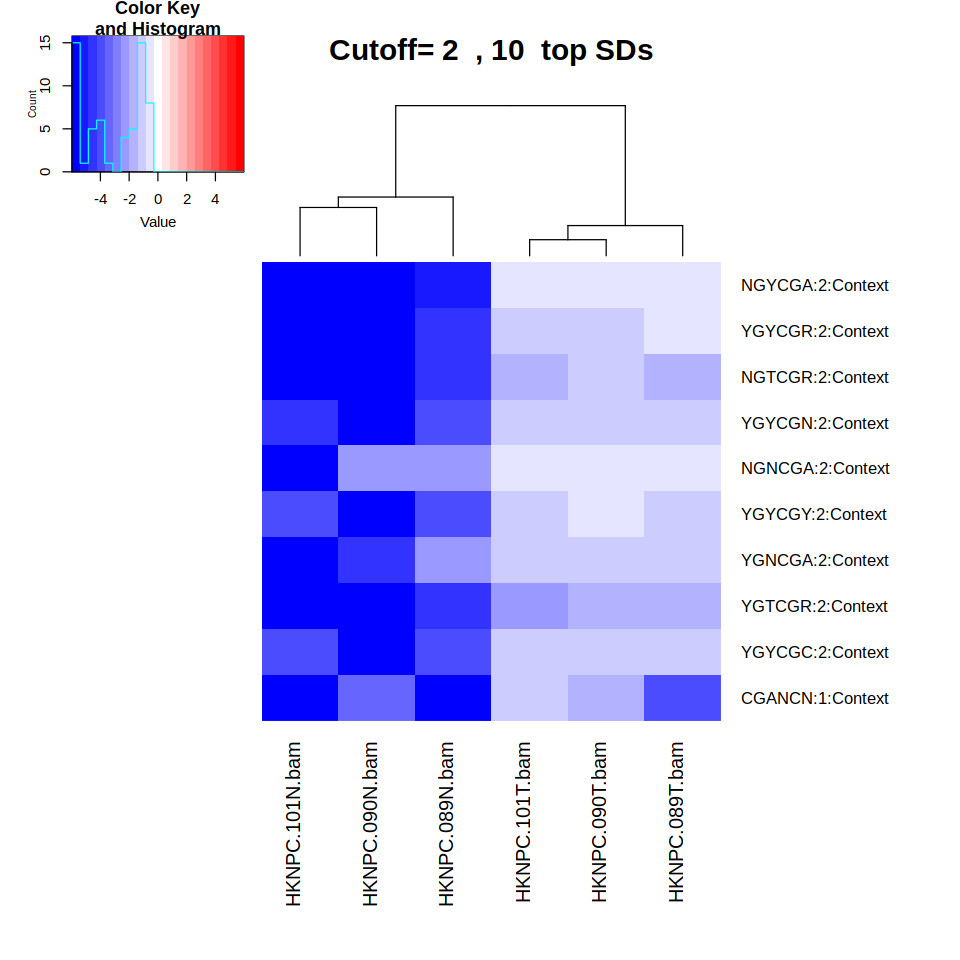

In [9]:

TOP_SDS <- 10
CUTOFF = 2

profile_cutoffed <- cutoff_complete_cases(CUTOFF, profile_6)

options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow = c(3, 2))  # Set the plot layout to 2x2
for (col in 1:ncol(profile_cutoffed)) {
  hist(profile_cutoffed[, col],main = colnames(profile_cutoffed)[col], xlab = "Qerr", breaks = 40,
  ,cex.axis = 1.4,  cex.lab = 1.4,cex.main = 1.5)
  abline(v = CUTOFF, col = "red", lty = "dashed", lwd = 2)
  abline(v = -CUTOFF, col = "red", lty = "dashed", lwd = 2)
}


# library(ggcorrplot)
invisible(capture.output({
  library(ggplot2)
  library(gplots)
}))
main_title = paste("Cutoff=", CUTOFF, " ,", TOP_SDS, " top SDs")
# mtext("Super Title", outer = TRUE, cex = 1.5, line = 1)
par(mar = c(5, 6, 4, 2))
heatmap.2(as.matrix(cutoff_and_get_top_sds(TOP_SDS, 0, profile_6)),  
  cexRow = 1, cexCol = 1.2, margins =c(12,12), scale = "none",
  main=main_title,
  trace = "none", Rowv=NA,
  col = colorRampPalette(c("blue", "white", "red"))(21),  
  lty = 2, lwd = 0.5)

### **Metrics for correct clutering**
1) Purity-based Clustering Index (**PCI**) - correctness of clustering
2) **Silhouette-score** - Overall clustering quality (homogenity + seperation)

In [4]:
library(ggplot2)
create_grid_heatmap <- function(grid_df, grid_title, inversed_colors=FALSE){
  df<-grid_df
  df$row <- factor(rownames(grid_df), levels = rownames(grid_df))
  # df$row <- rownames(grid_df)
  df <- tidyr::pivot_longer(df, -row, names_to = "col", values_to = "value")

low_color   = ifelse(inversed_colors, "royalblue", "white")
high_color  = ifelse(inversed_colors, "white", "royalblue")

# Create the heatmap using ggplot2
  plot <- ggplot(df, aes(x = col, y = row, fill = value)) + 
    geom_tile(color = "gray70") +
    scale_fill_gradient(low = low_color, high = high_color) +
    geom_text(aes(label = value), fontface = "bold", color = "black", size=5) +
    labs(title = grid_title, x = "cutoff", y = "top_sds#") +
        theme_bw() +
    theme(
      text = element_text(size = 15, face = "bold"),
      axis.text = element_text(size = 15, face = "bold"),
      legend.title = element_text(face = "bold"),
      legend.text = element_text(face = "bold")
    )
  return(plot)
}

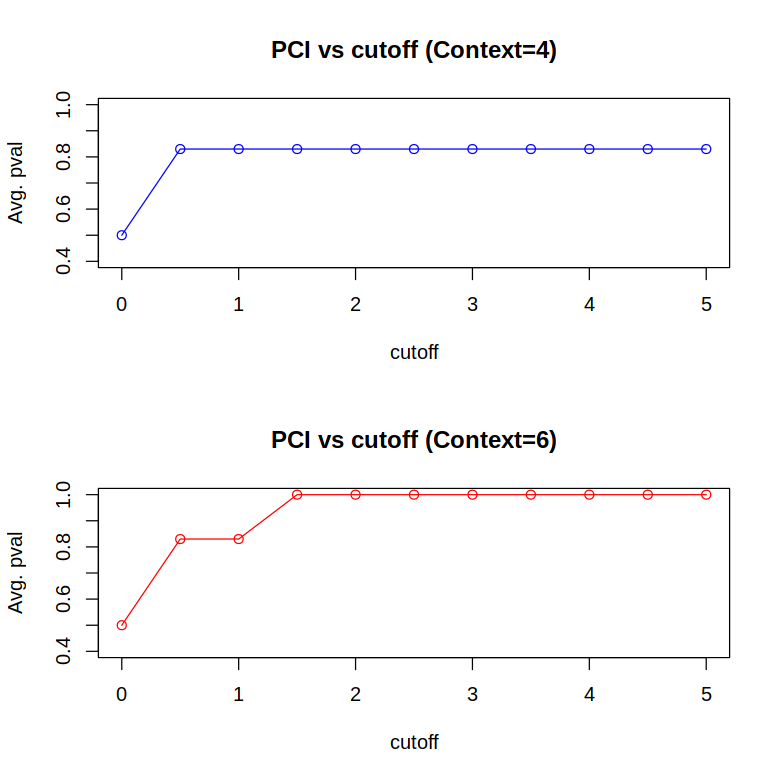

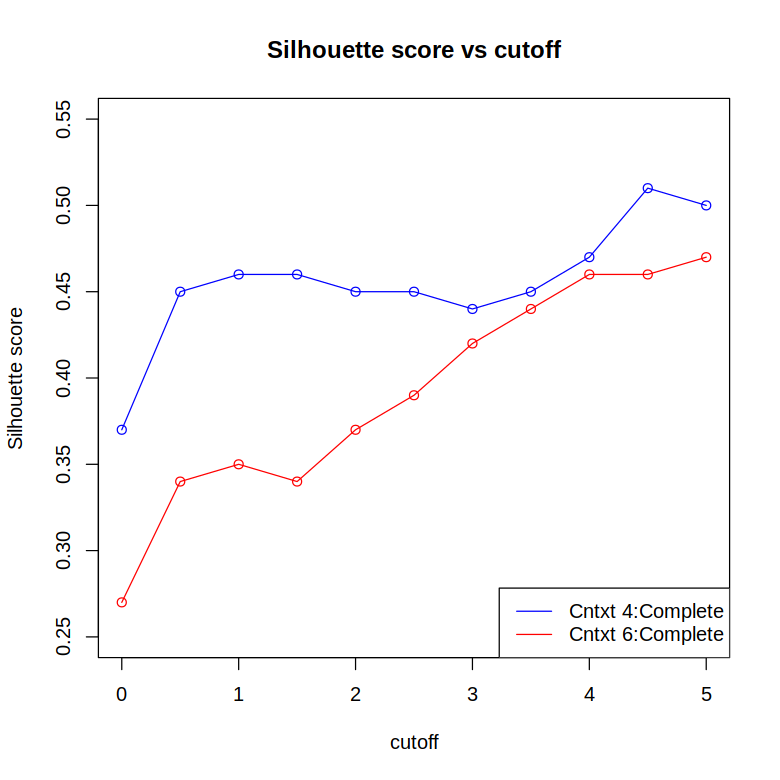

In [5]:
cutoffs <- seq(0, 5, by = 0.5)
# Silhouette score
complete_cases_pci_4 <- lapply(cutoffs, function(x) {
    cutoff_and_get_PCI( x, profile_4)
})

complete_cases_pci_pvals_6 <- lapply(cutoffs, function(x) {
    cutoff_and_get_PCI( x, profile_6)
})


complete_cases_si_4 <- lapply(cutoffs, function(x) {
    cutoff_and_get_silhouette_score( x, profile_4)
})

complete_cases_si_pvals_6 <- lapply(cutoffs, function(x) {
    cutoff_and_get_silhouette_score( x, profile_6)
})

options(repr.plot.width = 6.5, repr.plot.height = 6.5)
par(mfrow = c(2, 1))
plot(cutoffs, complete_cases_pci_4, type = "o",col="blue", xlab = "cutoff", ylab = "Avg. pval", main = "PCI vs cutoff (Context=4)", ylim = c(0.4,1))
plot(cutoffs, complete_cases_pci_pvals_6, type = "o", col="red", xlab = "cutoff", ylab = "Avg. pval", main = "PCI vs cutoff (Context=6)", ylim = c(0.4,1))

par(mfrow = c(1, 1))
plot(cutoffs, complete_cases_si_4, type = "o",  col="blue", xlab = "cutoff", ylab = "Silhouette score", main = "Silhouette score vs cutoff", ylim = c(0.25,0.55))
lines(cutoffs, complete_cases_si_pvals_6 ,  type = "o", col = "red")
legend("bottomright", legend = c("Cntxt 4:Complete",  "Cntxt 6:Complete"), col = c("blue",  "red"), lty=c(1,1))



In [6]:
top_sds <- c(5, 10, 20, 50, 100, 200, 500, 1000, 5000, ALL_ROWS)
cutoffs <- seq(0, 5, by = 0.5)

pci_grid_4_df <- get_pci_grid(top_sds, cutoffs, profile_4)
pci_grid_6_df <- get_pci_grid(top_sds, cutoffs, profile_6)

silhouette_grid_4_df <- get_silhouette_grid(top_sds, cutoffs, profile_4)
silhouette_grid_6_df <- get_silhouette_grid(top_sds, cutoffs, profile_6)

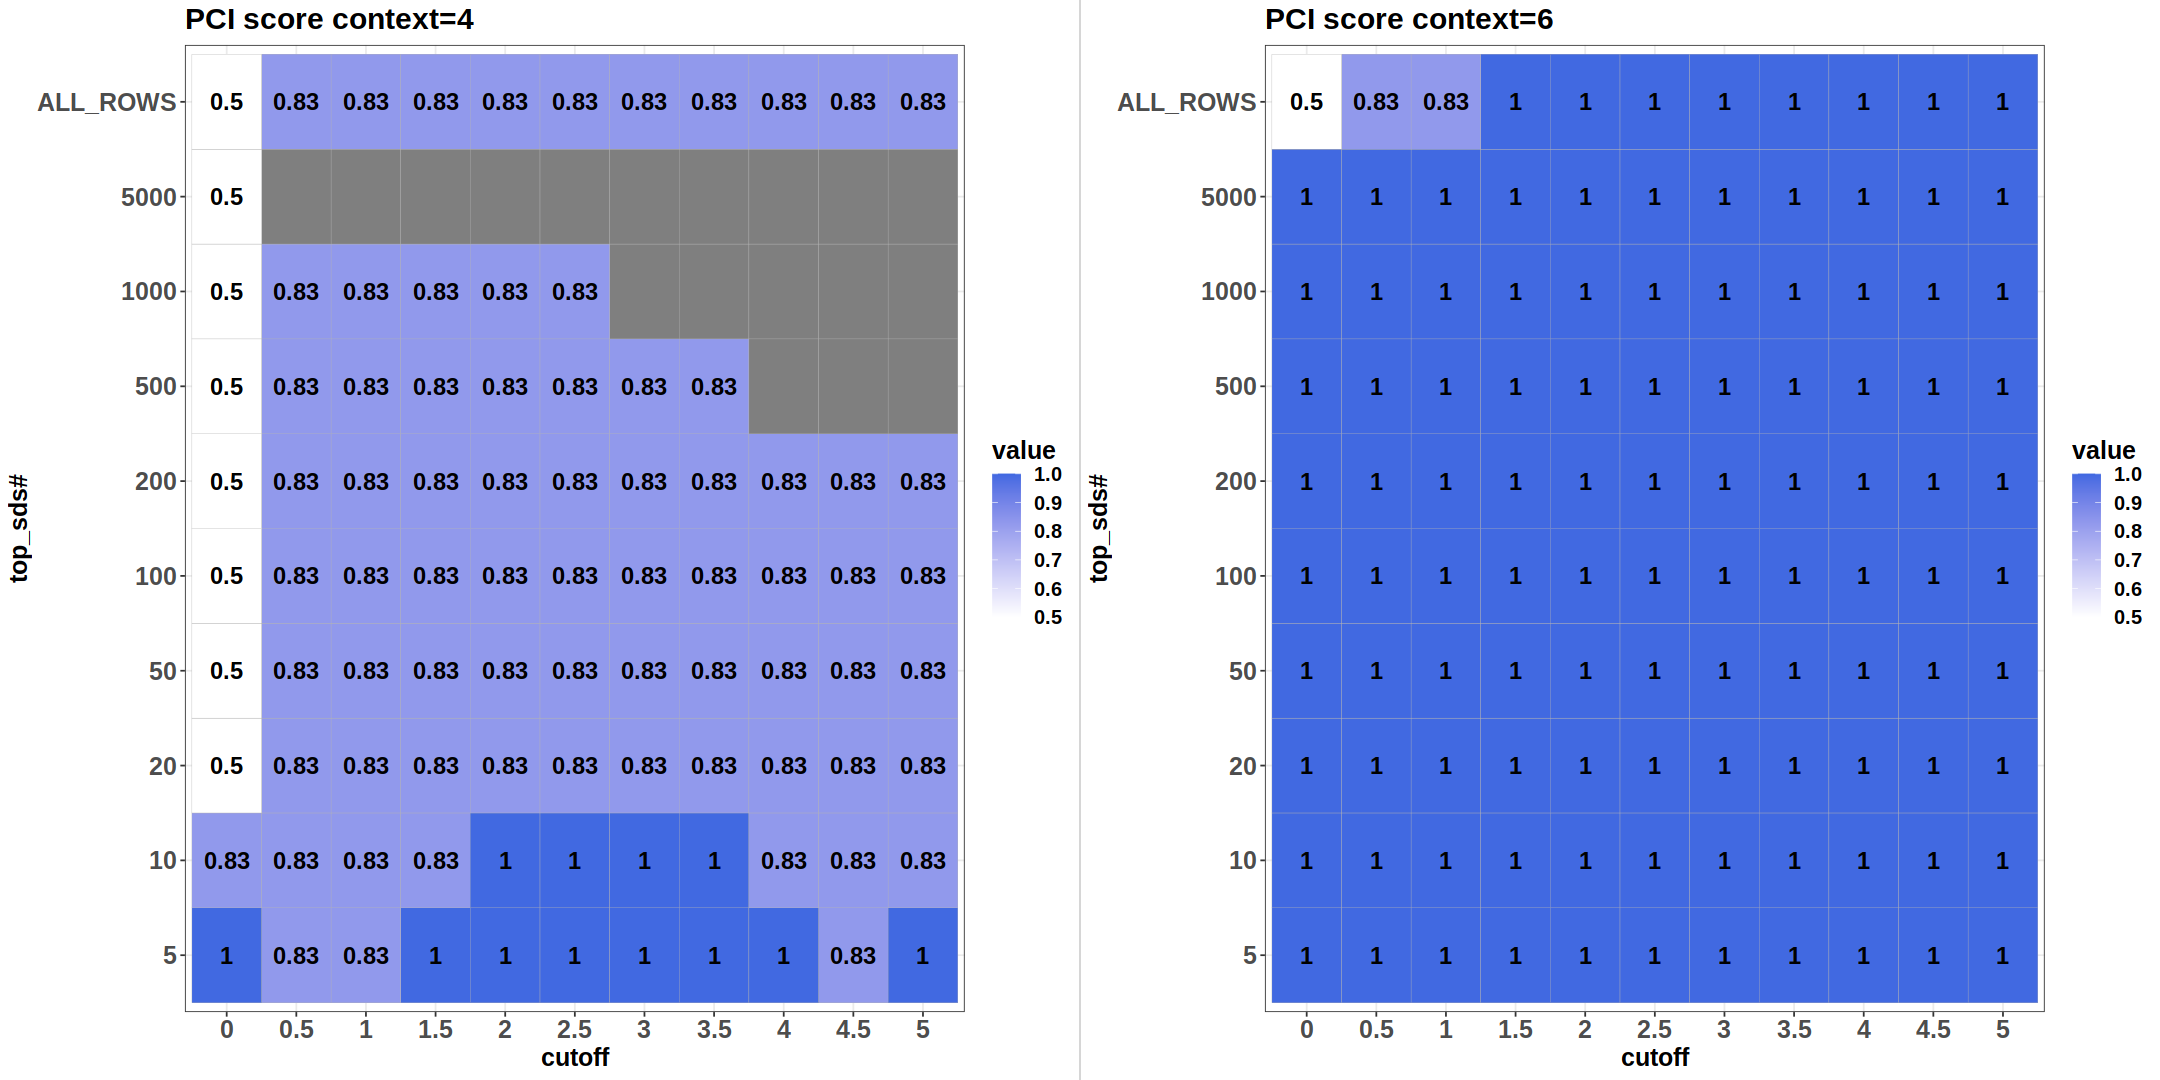

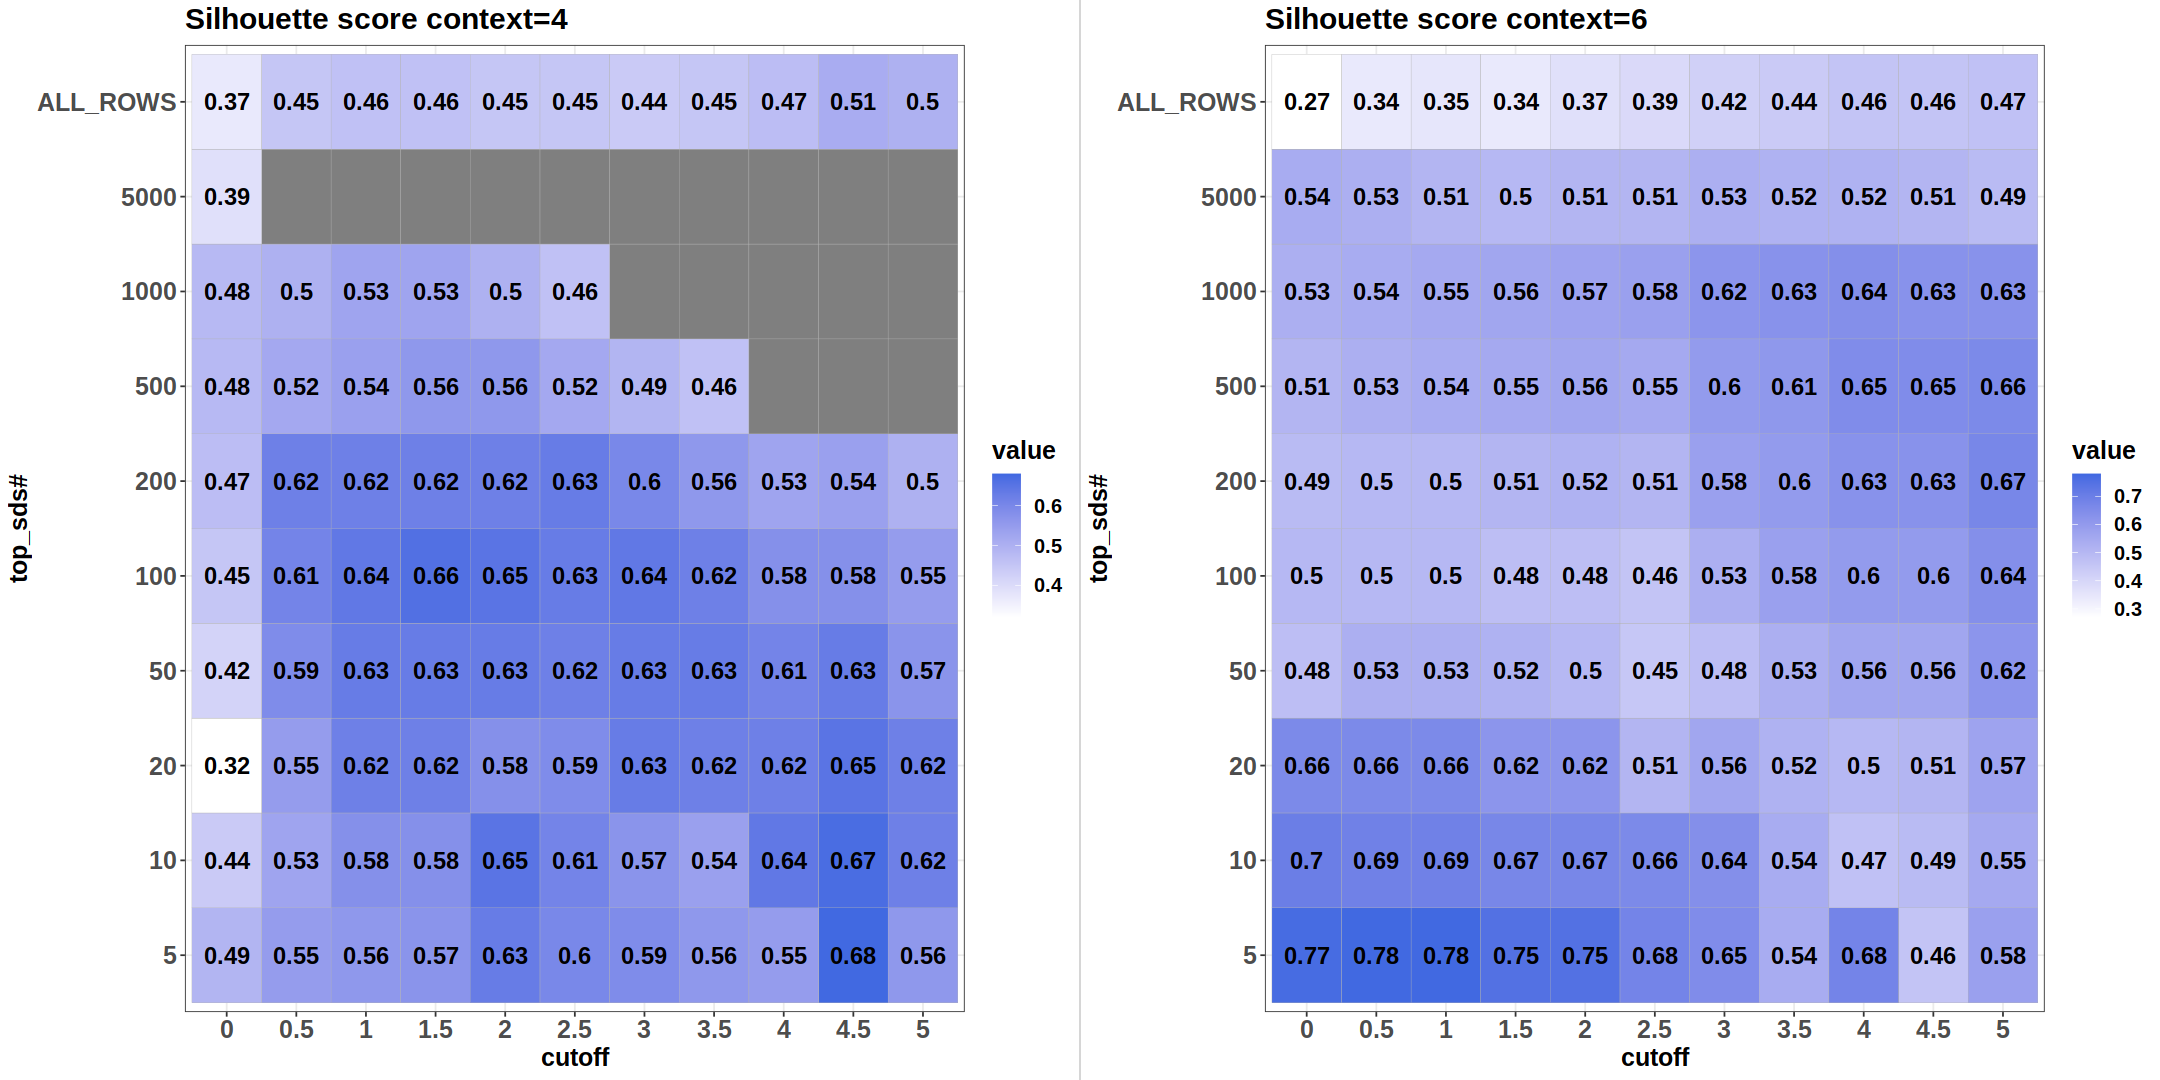

In [13]:
suppressWarnings({
    library(ggplot2)
    library(gridExtra)
    library(grid)


    # Arrange the plots side by side
    options(repr.plot.width = 18, repr.plot.height = 9)

    separator <- linesGrob(x = unit(c(0.5, 0.5), "npc"), y = unit(c(0, 1), "npc"),
                        gp = gpar(lwd = 1, col = "gray"))


    grid.arrange(
        create_grid_heatmap(pci_grid_4_df, "PCI score context=4"), 
        create_grid_heatmap(pci_grid_6_df, "PCI score context=6"), 
        ncol = 2)
    grid.draw(separator)


    grid.arrange(
        create_grid_heatmap(silhouette_grid_4_df, "Silhouette score context=4"), 
        create_grid_heatmap(silhouette_grid_6_df, "Silhouette score context=6"), 
        ncol = 2)
    grid.draw(separator)
})

### **Metrics for correct clutering (Cont.)**
3) **Average t-test pval** - metric for separation

In [8]:
cutoffs <- seq(0, 5, by = 0.5)


complete_cases_pvals_4 <- lapply(cutoffs, function(x) {
    get_avg_ttest_profile( x, profile_4)
})

complete_cases_pvals_6 <- lapply(cutoffs, function(x) {
    get_avg_ttest_profile( x, profile_6)
})

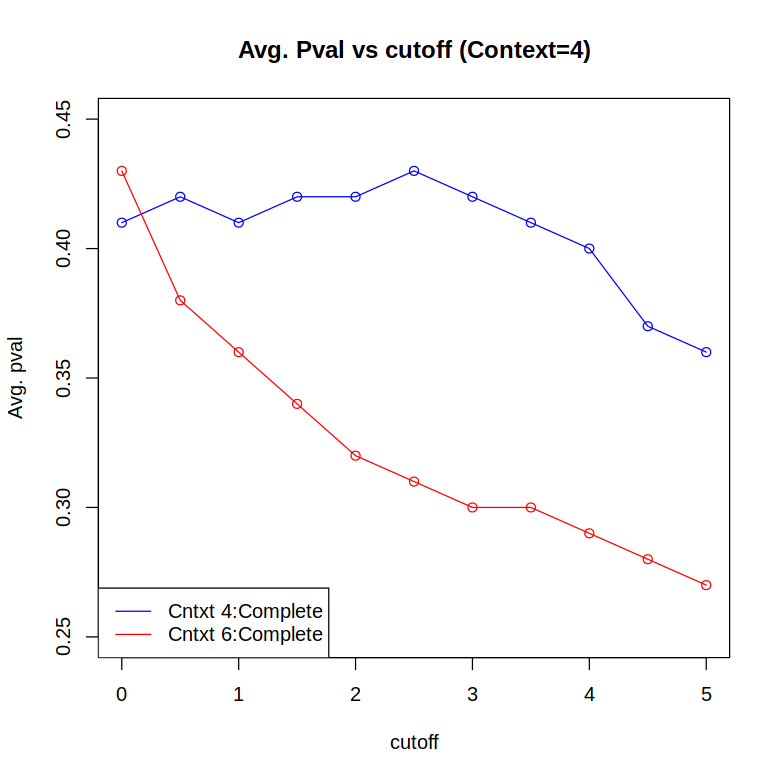

In [9]:
# par(mfrow = c(1, 2)) 
options(repr.plot.width = 6.5, repr.plot.height = 6.5)

plot(cutoffs, complete_cases_pvals_4, type = "o",  col="blue", xlab = "cutoff", ylab = "Avg. pval", main = "Avg. Pval vs cutoff (Context=4)", ylim = c(0.25,0.45))
lines(cutoffs, complete_cases_pvals_6 ,  type = "o", col = "red")
legend("bottomleft", legend = c("Cntxt 4:Complete", "Cntxt 6:Complete"), col = c("blue",  "red"), lty = c(1,1))

In [10]:
top_sds <- c(5, 10, 20, 50, 100, 200, 500, 1000, 5000, ALL_ROWS)
cutoffs <- seq(0, 5, by = 0.5)


avg_grid_4_df <- get_avg_ttest_grid(top_sds, cutoffs, profile_4)
avg_grid_6_df <- get_avg_ttest_grid(top_sds, cutoffs, profile_6)

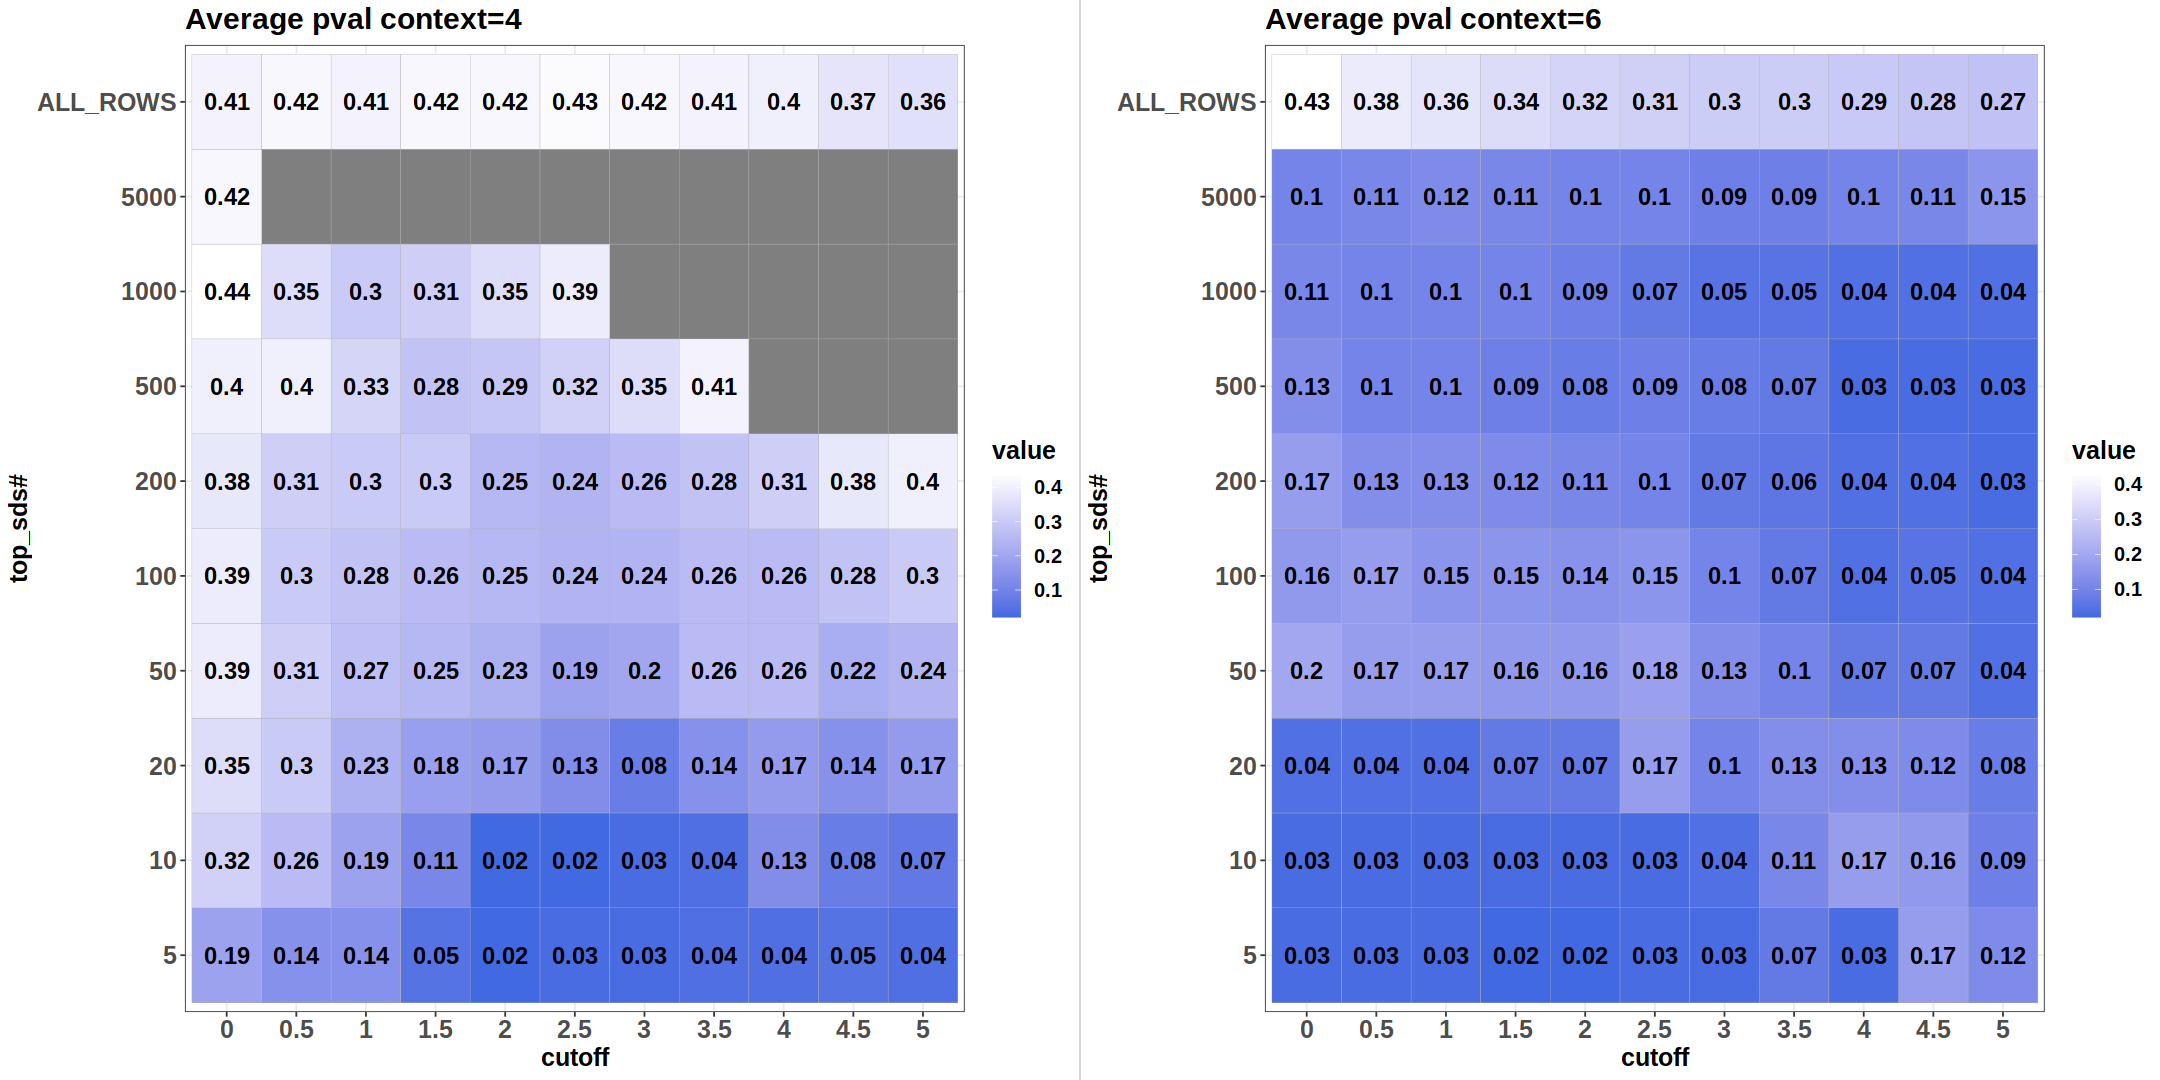

In [14]:
suppressWarnings({
    library(ggplot2)
    library(gridExtra)
    library(grid)

# Arrange the plots side by side
options(repr.plot.width = 18, repr.plot.height = 9)

separator <- linesGrob(x = unit(c(0.5, 0.5), "npc"), y = unit(c(0, 1), "npc"),
                       gp = gpar(lwd = 1, col = "gray"))


grid.arrange(
    create_grid_heatmap(avg_grid_4_df, "Average pval context=4", inversed_colors = TRUE), 
    create_grid_heatmap(avg_grid_6_df, "Average pval context=6", inversed_colors = TRUE), 
    ncol = 2)
grid.draw(separator)

})

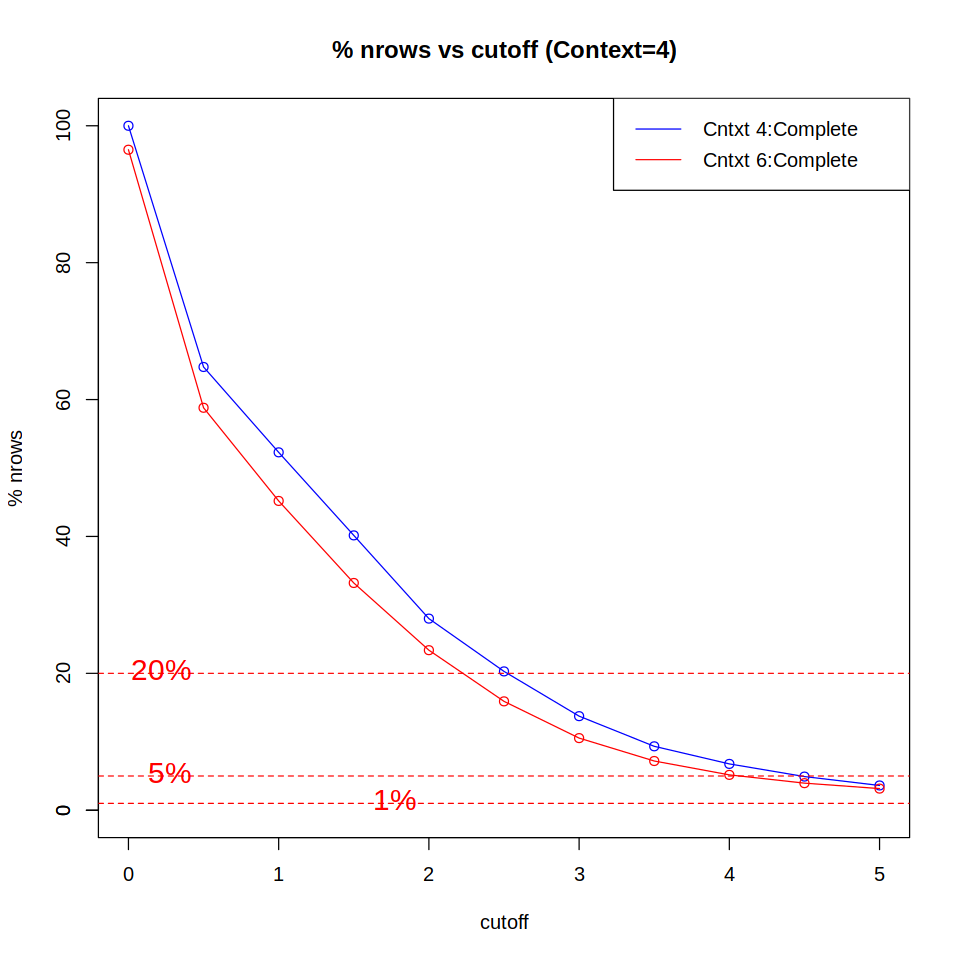

In [12]:
cutoffs <- seq(0, 5, by = 0.5)

complete_4_precentage <- lapply(cutoffs, function(x) {
    cleaned_scaled_prf <- cutoff_scale_complete_cases(x, profile_4)
    (nrow(cleaned_scaled_prf)/nrow(profile_4))*100
})

complete_6_precentage <- lapply(cutoffs, function(x) {
    cleaned_scaled_prf <- cutoff_scale_complete_cases(x, profile_6)
    (nrow(cleaned_scaled_prf)/nrow(profile_6))*100
})

options(repr.plot.width = 8, repr.plot.height = 8)

plot(cutoffs, complete_4_precentage, type = "o",  col="blue", xlab = "cutoff", ylab = "% nrows", main = "% nrows vs cutoff (Context=4)", ylim = c(0,100))
# lines(cutoffs, imputed_4_precentage, type = "o", lty = 2, col = "blue")
lines(cutoffs, complete_6_precentage ,  type = "o", col = "red")
# lines(cutoffs, imputed_6_precentage, type = "o", lty = 2, col = "red")

abline(h = 20, col = "red", lty = "dashed")
text(0.5, 20, "20%", pos = 2, col = "red", cex=1.5)
abline(h = 5, col = "red", lty = "dashed")
text(0.5, 5, "5%", pos = 2, col = "red", cex=1.5)
abline(h = 1, col = "red", lty = "dashed")
text(2, 1, "1%", pos = 2, col = "red", cex=1.5)

axis(side=2 , at=seq(0,100,120))

legend("topright", legend = c("Cntxt 4:Complete", "Cntxt 6:Complete"), col = c("blue",  "red"), lty = c(1,1))